# Linear and Logistic Regression in Tensorflow

## Linear Regression in Tensorflow
-----
    Dataset Description:
    Name: Fire and Theft in Chicago
    X = fires per 1000 housing units
    Y = thefts per 1000 population

    within the same Zip code in the Chicago metro area
    Total number of Zip code areas: 42
    
    Solution:
    First, assume that the relationship between the number of fires and thefts are linear:
    Y = wX + b

    another try:
    Y = wXX + uX + b

w=1.7183813 b=15.789157
loss=25.375277


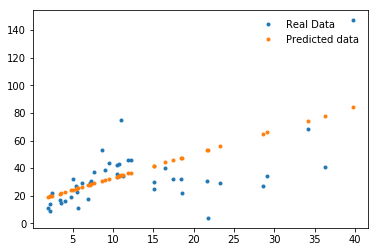

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import xlrd

DATA_FILE = "data/slr05.xls"

# Step 1: read in data from the .xls file
book = xlrd.open_workbook(DATA_FILE, encoding_override="utf-8")
sheet = book.sheet_by_index(0)
data = np.asarray([sheet.row_values(i) for i in range(1, sheet.nrows)])
n_samples = sheet.nrows - 1

# Step 2: create placeholders for input X (number of fire) and label Y (number of theft)
X = tf.placeholder(tf.float32, name="X")
Y = tf.placeholder(tf.float32, name="Y")

# Step 3: create weight and bias, initialized to 0
w = tf.Variable(0.0, name="weights")
# w_2 = tf.Variable(0.0, name="weights 2")
b = tf.Variable(0.0, name="bias")

# Step 4: construct model to predict Y (number of theft) from the number of fire
Y_predicted = X * w + b
#Y_predicted = X * X * w + X * u + b

# Step 5: use the square error as the loss function
loss = tf.square(Y - Y_predicted, name="loss")

# Step 6: using gradient descent with learning rate of 0.01 to minimize loss
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss)

x_r = []
y_r = []
with tf.Session() as sess:
    # Step 7: initialize the necessary variables, in this case, w and b
    sess.run(tf.global_variables_initializer())
    
    # Step 8: train the model
    for i in range(100): # run 100 epochs
        for x, y in data:
            # Session runs train_op to minimize loss
            sess.run(optimizer, feed_dict={X: x, Y:y})
    
    # Step 9: output the values of w and b
    w_value, b_value = sess.run([w, b])
    print("w=%r b=%r" % (w_value, b_value))
    for x, y in data:
        x_r.append(x)
        y_r.append(sess.run(Y_predicted, feed_dict={X: x, Y:y}))
    
    # plot
    loss_r = sess.run(loss, feed_dict={X: x, Y:y})
    print("loss=%r" % loss_r)
    
    plt.figure('linear regression')
    plt.plot(data[:,0], data[:,1], '.', label="Real Data")
    plt.plot(x_r, y_r, '.', label="Predicted data")
    plt.legend(loc='upper right', frameon=False)

## Optimizer
---------------
        GradientDescentOptimizer means that our update rule is gradient descent. TensorFlow does auto differentiation for us, then update the values of w and b to minimize the loss.
        By default, the optimizer trains all the trainable variables whose objective function depend on. If there are variables that you do not want to train, you can set the keyword trainable to False when you declare a variable. One example of a variable you don’t want to train is the variable global_step, a common variable you will see in many TensorFlow model to keep track of how many times you’ve run your model.

```python
global_step = tf.Variable(0, trainable=False, dtype=tf.int32) # global step counter
learning_rate = 0.01 * 0.99 ** tf.cast(global_step, tf.float32) # convert from int32 to float32
increment_step = global_step.assign_add(1) # ???
optimizer = tf.GradientDescentOptimizer(learning_rate) # learning rate can be a tensor
train_op = optimizer.minimize(loss, global_step=increment_step)
```

You can also ask your optimizer to take gradients of specific variables. You can also modify the
gradients calculated by your optimizer.

```python
# create an optimizer.
optimizer = GradientDescentOptimizer(learning_rate=0.1)
# compute the gradients for a list of variables.
grads_and_vars = opt.compute_gradients(loss, <list of variables>)
# grads_and_vars is a list of tuples (gradient, variable). Do whatever you
# need to the 'gradient' part, for example, subtract each of them by 1.
subtracted_grads_and_vars = [(gv[0] - 1.0, gv[1]) for gv in grads_and_vars]
# ask the optimizer to apply the subtracted gradients.
optimizer.apply_gradients(subtracted_grads_and_vars)
```

## Logistic Regression in TensorFlow
------

In [6]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# Step 1: Read in data
# using TF Learn's built in function to load MNIST data to the folder data/mnist
MNIST = input_data.read_data_sets("./data/mnist", one_hot=True)

# Step 2: Define parameters for the model
learning_rate = 0.01
batch_size = 128
n_epochs = 25

# Step 3: create placeholders for features and labels
# each image in the MNIST data is of shape 28*28 = 784
# therefore, each image is represented with a 1x784 tensor
# there are 10 classes for each image, corresponding to digits 0 - 9.
# each label is one hot vector.
X = tf.placeholder(tf.float32, [batch_size, 784])
Y = tf.placeholder(tf.float32, [batch_size, 10])

# Step 4: create weights and bias
# w is initialized to random variables with mean of 0, stddev of 0.01
# b is initialized to 0
# shape of w depends on the dimension of X and Y so that Y = tf.matmul(X, w)
# shape of b depends on Y
w = tf.Variable(tf.random_normal(shape=[784, 10], stddev=0.01), name="weights")
b = tf.Variable(tf.zeros([1, 10]), name="bias")

# Step 5: predict Y from X and w, b
# the model that returns probability distribution of possible label of the image
# through the softmax layer
# a batch_size x 10 tensor that represents the possibility of the digits
logits = tf.matmul(X, w) + b

# Step 6: define loss function
# use softmax cross entropy with logits as the loss function
# compute mean cross entropy, softmax is applied internally
entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y)
loss = tf.reduce_mean(entropy) # computes the mean over examples in the batch

# Step 7: define training op
# using gradient descent with learning rate of 0.01 to minimize cost
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)
init = tf.global_variables_initializer()
with tf.Session() as sess:
    writer = tf.summary.FileWriter('./graphs/logistic_reg', sess.graph)
    
    sess.run(init)
    n_batches = int(MNIST.train.num_examples/batch_size)
    for i in range(n_epochs): # train the model n_epochs times
        for _ in range(n_batches):
            X_batch, Y_batch = MNIST.train.next_batch(batch_size)
            _, loss_r = sess.run([optimizer, loss], feed_dict={X: X_batch, Y:Y_batch})

    # average loss should be around 0.35 after 25 epochs
    print("n_batches=%r test_num=%r loss=%r" % (n_batches, MNIST.train.num_examples, loss_r))
    
    # test the model
    total_correct_preds = 0
    for i in range(n_batches):
        X_batch, Y_batch = MNIST.test.next_batch(batch_size)
        preds = tf.nn.softmax(logits)
        correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(Y_batch, 1))
        accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32))
        total_correct_preds += sess.run(accuracy, feed_dict={X: X_batch, Y:Y_batch})
        #print("total_correct_preds=%r" % (total_correct_preds))
    print("total_correct_preds=%r Accuracy=%r" % (total_correct_preds, total_correct_preds/MNIST.test.num_examples))
    
    writer.close()

Extracting ./data/mnist\train-images-idx3-ubyte.gz
Extracting ./data/mnist\train-labels-idx1-ubyte.gz
Extracting ./data/mnist\t10k-images-idx3-ubyte.gz
Extracting ./data/mnist\t10k-labels-idx1-ubyte.gz
n_batches=429 test_num=55000 loss=0.40479055
total_correct_preds=50009.0 Accuracy=5.0008999999999997
